# Google Drive mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip3 install -r $ROOT_PATH/requirements.txt --quiet

ModuleNotFoundError: No module named 'google'

# Imports and constants

In [1]:
import sys
sys.path.append("..")
from src.utils import get_filename, inliers_path, metadata_path, cropped_coins_path, side_path, aligned_coins_path, MARCINIAK_DATASET_PATH, NIEMCZYK_DATASET_PATH
import cv2

REF_IMG_DICT = {
    1: cv2.imread(cropped_coins_path(MARCINIAK_DATASET_PATH)+ "/35_1.jpg"),
    2: cv2.imread(cropped_coins_path(MARCINIAK_DATASET_PATH)+ "/35_2.jpg"),
}

In [2]:
import numpy as np

from tqdm.notebook import tqdm
from time import sleep
import pandas as pd
from src.detector import create_circular_mask 
from matplotlib import pyplot as plt
from scipy.spatial import distance
from silx.opencl import sift as silx_sift

In [3]:
%whos

Variable                 Type                          Data/Info
----------------------------------------------------------------
MARCINIAK_DATASET_PATH   str                           /Users/telepchuk/PWr/Dan <...>a/marciniak/sztandar_1930
NIEMCZYK_DATASET_PATH    str                           /Users/telepchuk/PWr/Dan <...>ta/niemczyk/sztandar_1930
REF_IMG_DICT             dict                          n=2
aligned_coins_path       function                      <function <lambda> at 0x1032b8430>
create_circular_mask     function                      <function create_circular_mask at 0x117dece50>
cropped_coins_path       function                      <function <lambda> at 0x1032b84c0>
cv2                      module                        <module 'cv2.cv2' from '/<...>v2.cpython-38-darwin.so'>
distance                 module                        <module 'scipy.spatial.di<...>ipy/spatial/distance.py'>
get_filename             function                      <function get_filename at 0x10


# Alignment environment


In [48]:
def remove_illumination(im, kernel_shape=(61,61)):
    assert len(im.shape) == 2
    im_orig = im.copy()
    back = cv2.GaussianBlur(im, kernel_shape, 0)
    im = im.astype("float")
    im = np.subtract(im, back)
    im = im + np.mean(back) 

    mask = create_circular_mask(im.shape[0], im.shape[1])
    im[~mask] = 0

    im[im < 0] = 0
    im[im > 255] = 255
    im = np.uint8(im)
    return im

In [79]:
DATASET_PATH = NIEMCZYK_DATASET_PATH

src_im_orig = REF_IMG_DICT[1]
dst_im_orig = cv2.imread(cropped_coins_path(DATASET_PATH) + '/69_1.jpg')

src_h, src_w = src_im_orig.shape[:2]
dst_h, dst_w = dst_im_orig.shape[:2]

ds_size = 800
ds_src_ratio = ds_size / src_h 
ds_dst_ratio = ds_size / dst_h

src_im = cv2.resize(src_im_orig, (ds_size, ds_size))
dst_im = cv2.resize(dst_im_orig, (ds_size, ds_size))

In [117]:
use_silx_sift = False
if use_silx_sift:
    sift = silx_sift.SiftPlan(template=src_im, devicetype="CPU")

    src_gray = cv2.cvtColor(src_im, cv2.COLOR_BGR2GRAY)
    dst_gray = cv2.cvtColor(dst_im, cv2.COLOR_BGR2GRAY)

    src_kp = sift.keypoints(src_gray, None)
    src_des = np.asarray([p.desc for p in src_kp]).astype('float32')
    src_kp = [cv2.KeyPoint(x=p.x, y=p.y, _size=p.scale, _angle=np.rad2deg(p.angle)) for p in src_kp]

    dst_kp = sift.keypoints(dst_gray, None)
    dst_des = np.asarray([p.desc for p in dst_kp]).astype('float32')
    dst_kp = [cv2.KeyPoint(x=p.x, y=p.y, _size=p.scale, _angle=np.rad2deg(p.angle)) for p in dst_kp]
else:
    sift = cv2.SIFT_create()

    src_gray = cv2.cvtColor(src_im, cv2.COLOR_BGR2GRAY)
    dst_gray = cv2.cvtColor(dst_im, cv2.COLOR_BGR2GRAY)

    src_gray = remove_illumination(src_gray, (41,41))
    dst_gray = remove_illumination(dst_gray, (41,41))
  
    src_kp, src_des = sift.detectAndCompute(src_gray, None)
    dst_kp, dst_des = sift.detectAndCompute(dst_gray, None)

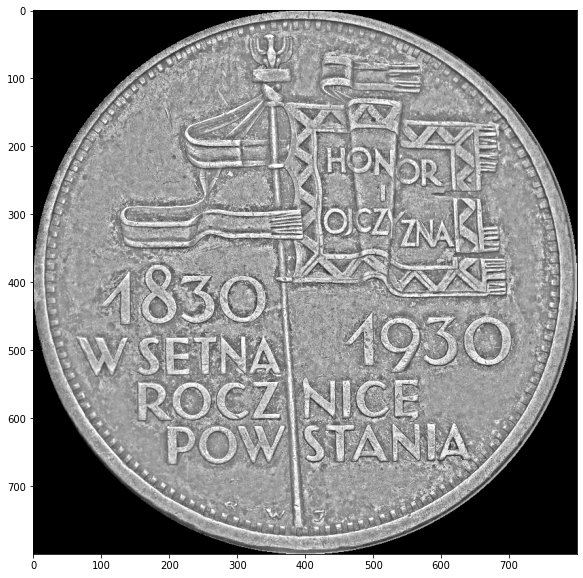

In [118]:
plt.figure(figsize=(10,10))
plt.imshow(dst_gray, cmap='gray')

## Best matching

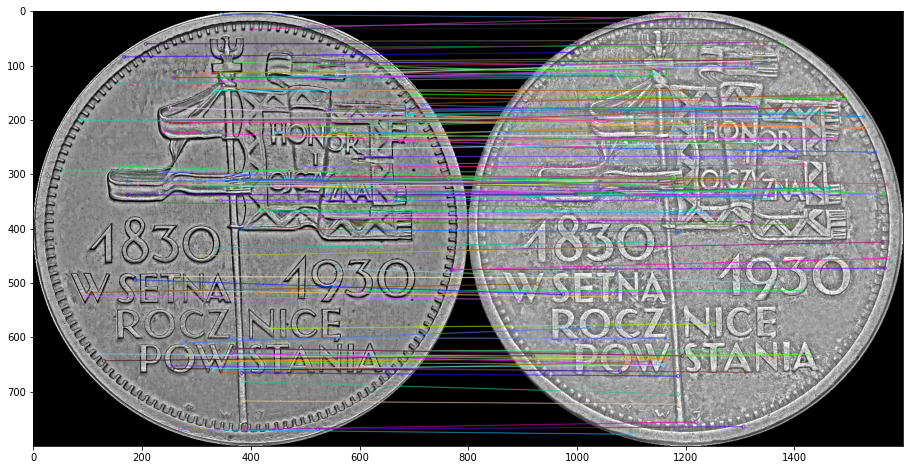

In [130]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.match(src_des, dst_des)

# matches = sorted(matches, key = lambda x:x.distance)
# matches = matches[:int(len(matches)*0.7)]
matches = sorted(matches, key = lambda x: distance.euclidean( src_kp[x.queryIdx].pt , dst_kp[x.trainIdx].pt, src_h ))
matches = matches[:len(matches)][:150]

matches_im = cv2.drawMatches(
#                             cv2.cvtColor(src_im, cv2.COLOR_BGR2RGB),
                             src_gray,
                             src_kp,
#                              cv2.cvtColor(dst_im, cv2.COLOR_BGR2RGB),
                             dst_gray,
                             dst_kp,
                             matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(16,8))
plt.imshow(matches_im)
plt.show()

In [135]:
src_pts = np.float32([ np.divide(src_kp[m.queryIdx].pt, ds_src_ratio) for m in matches ]).reshape(-1,1,2)
dst_pts = np.float32([ np.divide(dst_kp[m.trainIdx].pt, ds_dst_ratio) for m in matches ]).reshape(-1,1,2)
# M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
M, inliers = cv2.estimateAffinePartial2D (src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold = 8.0, confidence=0.99)
n_inliers = inliers.ravel().sum()

tx = -int(M[0,2])
ty = -int(M[1,2])
scale = np.sqrt(M[1,0]**2 + M[0,0]**2)
a = -np.arctan(M[1,0]/M[0,0])
M_R = np.array([[np.cos(a), -np.sin(a), tx],\
                [np.sin(a),  np.cos(a), ty]])

new_h = int(src_h*scale)
res_im = cv2.warpAffine(dst_im_orig, M_R, (new_h, new_h))

mask = create_circular_mask(
    h = new_h,
    w = new_h,
)

res_im[~mask] = 0
# res_im = cv2.resize(dst_im_orig, (new_h, new_h))

In [136]:
new_h, res_im.shape, n_inliers

(2536, (2536, 2536, 3), 20)

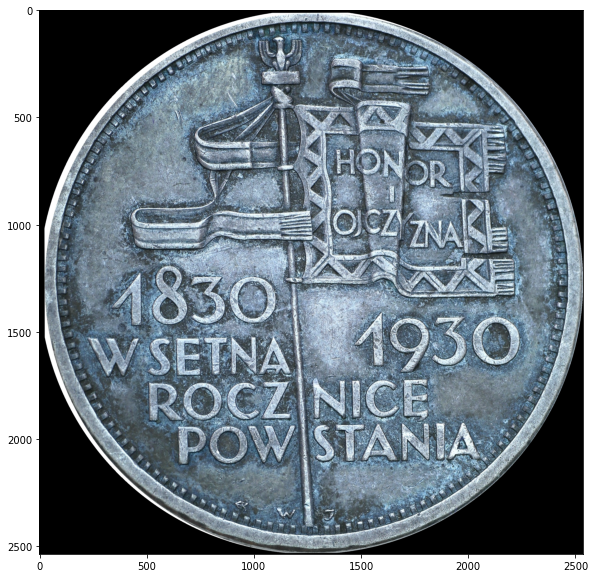

In [137]:
plt.figure(figsize=(10,10))
plt.imshow(res_im, cmap='gray');

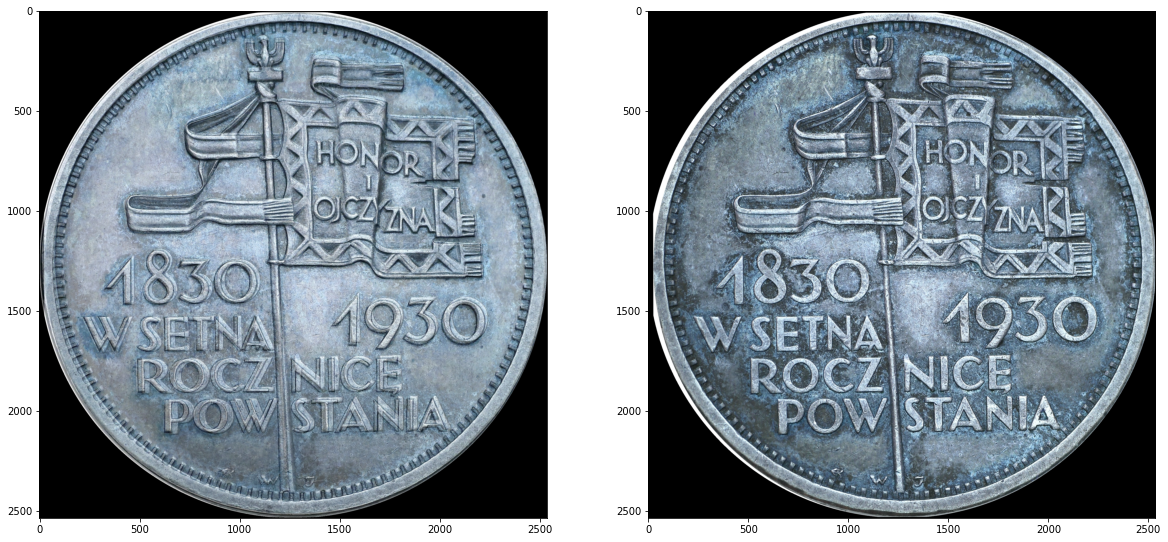

In [134]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(np.uint8(cv2.resize(src_im_orig, (new_h, new_h)) * 0.5 + res_im * 0.5))

ax2.imshow(res_im)
plt.show()

# Final method

In [140]:
def align_with_reference(dst_im_orig,
  src_im_orig,
  ds_size = 800,
  matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False),
  use_silx_sift=False,
  maxIter=2000,
  name=None):
    src_h, src_w = src_im_orig.shape[:2]
    dst_h, dst_w = dst_im_orig.shape[:2]

#     assert src_h == src_w
#     assert dst_h == dst_w

    ds_size = min(ds_size, dst_h)
    ds_src_ratio = ds_size / src_h 
    ds_dst_ratio = ds_size / dst_h

    src_im = cv2.resize(src_im_orig, (ds_size, ds_size))
    dst_im = cv2.resize(dst_im_orig, (ds_size, ds_size))

    if use_silx_sift:
        sift = silx_sift.SiftPlan(template=src_im, devicetype="CPU")

        src_gray = cv2.cvtColor(src_im, cv2.COLOR_BGR2GRAY)
        dst_gray = cv2.cvtColor(dst_im, cv2.COLOR_BGR2GRAY)

        src_kp = sift.keypoints(src_gray, None)
        src_des = np.asarray([p.desc for p in src_kp]).astype('float32')
        src_kp = [cv2.KeyPoint(x=p.x, y=p.y, _size=p.scale, _angle=np.rad2deg(p.angle)) for p in src_kp]

        dst_kp = sift.keypoints(src_gray, None)
        dst_des = np.asarray([p.desc for p in dst_kp]).astype('float32')
        dst_kp = [cv2.KeyPoint(x=p.x, y=p.y, _size=p.scale, _angle=np.rad2deg(p.angle)) for p in dst_kp]
    else:
        sift = cv2.SIFT_create()

        src_gray = cv2.cvtColor(src_im, cv2.COLOR_BGR2GRAY)
        dst_gray = cv2.cvtColor(dst_im, cv2.COLOR_BGR2GRAY)

#         src_gray = cv2.medianBlur(src_im, 5)
#         dst_gray = cv2.medianBlur(dst_im, 5)

#         src_gray = cv2.Canny(src_gray, 0.3*255, 0.8*255)
#         dst_gray = cv2.Canny(dst_gray, 0.3*255, 0.8*255)
        src_gray = remove_illumination(src_gray, (65,65))
        dst_gray = remove_illumination(dst_gray, (65,65))

        src_kp, src_des = sift.detectAndCompute(src_gray, None)
        dst_kp, dst_des = sift.detectAndCompute(dst_gray, None)
        
    matches = matcher.match(src_des, dst_des)
#     matches = sorted(matches, key = lambda x:x.distance)
#     matches = matches[:int(len(matches)*0.7)]
    matches = sorted(matches, key = lambda x: distance.euclidean( src_kp[x.queryIdx].pt , dst_kp[x.trainIdx].pt, src_h ))
    matches = matches[:len(matches)][:150]

    MIN_MATCH_COUNT = 10
    
    src_pts = np.float32([ np.divide(src_kp[m.queryIdx].pt, ds_src_ratio) for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ np.divide(dst_kp[m.trainIdx].pt, ds_dst_ratio) for m in matches ]).reshape(-1,1,2)
    # M, inliers = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    M, inliers = cv2.estimateAffinePartial2D (src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold = 5.0, confidence=0.99
#                                               maxIters=maxIter
                                             )
    n_inliers = inliers.ravel().sum()

    tx = -int(M[0,2])
    ty = -int(M[1,2])
    scale = np.sqrt(M[1,0]**2 + M[0,0]**2)
    a = -np.arctan(M[1,0]/M[0,0])
    M_R = np.array([[np.cos(a), -np.sin(a), tx],\
                    [np.sin(a),  np.cos(a), ty]])

    new_h = int(src_h*scale)
    res_im = cv2.warpAffine(dst_im_orig, M_R, (new_h, new_h))

    mask = create_circular_mask(new_h, new_h)
    res_im[~mask] = 0
    
    if n_inliers < MIN_MATCH_COUNT:
        w = n_inliers/len(matches)
        k = maxIter
        p = 1 - np.exp(k * np.log(1 - w ** 2))
        print("{} Warning: probability of success with obtained inlisers is {}".format(name, p))

    return res_im, n_inliers


In [141]:
def align_all_coins(csv_path, in_root, out_root, labels, inliers_csv, use_silx_sift):
    df = pd.read_csv(csv_path)
    df["label"] = df["label"].astype("uint8")

    pbar = tqdm(total=len([l for l in df["label"] if l in labels]))

    for i, row in df.iterrows():
        name = row["name"]
        label = row["label"]
        if label not in labels:
            continue

        img = cv2.imread(in_root + "/" + name)
        ref_im = REF_IMG_DICT[label]
        aligned, n_inliers = align_with_reference(img, ref_im, use_silx_sift=use_silx_sift, name=name)
        cv2.imwrite(out_root + "/" + name, aligned)
        df.loc[i, "inliers"] = n_inliers
        df[['name', 'inliers']].to_csv(inliers_csv, index=None)

        pbar.update(1)
    
    pbar.close()

In [143]:
DATASET_PATH = MARCINIAK_DATASET_PATH
align_all_coins(
    side_path(DATASET_PATH),
    cropped_coins_path(DATASET_PATH),
    aligned_coins_path(DATASET_PATH),
    [1,2],
    inliers_csv=inliers_path(DATASET_PATH),
    use_silx_sift=False
)

  0%|          | 0/276 [00:00<?, ?it/s]

<ipython-input-140-9906f1c5e54a>:70: RuntimeWarning: invalid value encountered in double_scalars
  a = -np.arctan(M[1,0]/M[0,0])


24_2.jpg Warning: probability of success with obtained inlisers is 0.9992630504993144
3_3.jpg Warning: probability of success with obtained inlisers is 0.9872255113180826
57_3.jpg Warning: probability of success with obtained inlisers is 0.9992630504993144
